# Hybrid Response Analysis (HyRA)
HyRA decomposes a neural network into a parallel connection of a linear system and a non-linear system and demonstrates that the linear system functions as a low-pass filter while the non-linear system injects high-frequency information.


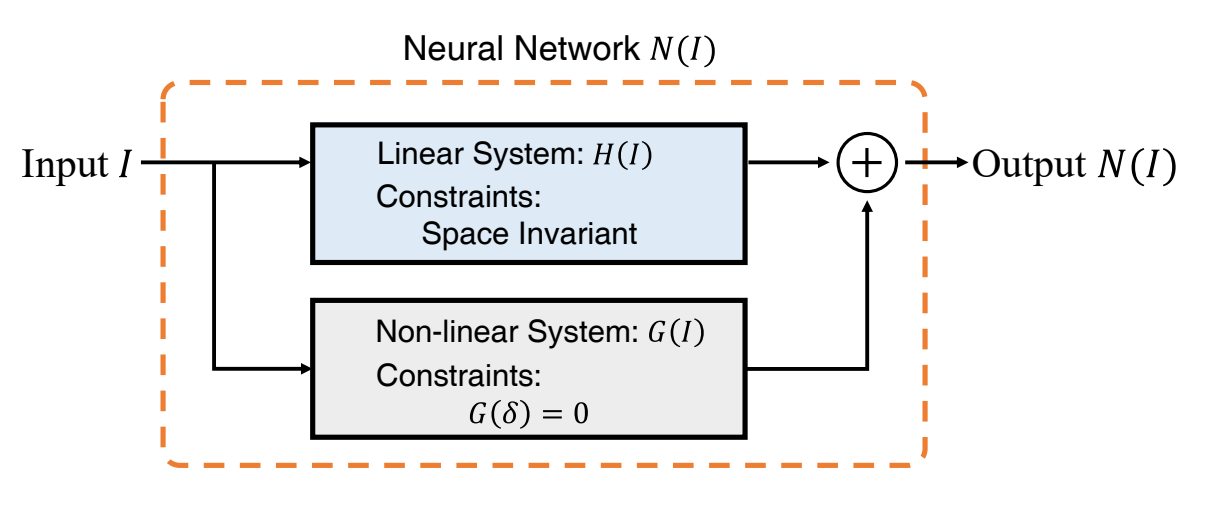

## Code usage
We provide a script to directly analyze a network using HyRA, i.e., `HyRA.py`. Here is the usage

```bash
python HyRA.py --lr [path to low-resolution image] --sr [path to super-resolution image, namely N(I) in the paper] --scale [the scale of super resolution] --impulse_response [path to impulse response] --save_path [path to save results]
```

This is an example of how to obtain Fig.14 in the paper:

In [6]:
!python HyRA.py --lr ./example_figures/lr.png --sr ./example_figures/sr.png --impulse_response ./example_figures/impulse_response.png --save_path ./HyRA_results --scale 3

done!


Now, your `HyRA_results` directory looks like:


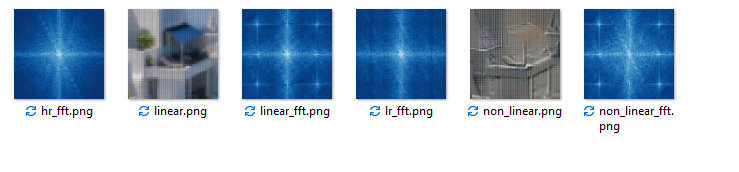

## Code explanation
Here, we provide a detailed explanation of our code.

We have five functions in `HyRA.py`:
- `normalize(ten:torch.Tensor)`: normalize the tensor before saving to an image file.
- `convertNp(img:torch.Tensor)`: adjust the tensor shape before saving to an image file.
- `get_linear(lr:torch.Tensor, impulse_response:torch.Tensor)`: calculate the linear part ($H(I)$ in our paper) using an lr image and the impulse response.
- `get_nonlinear(linear:torch.Tensor, sr:torch.Tensor)`: get the non-linear part ($G(I)$ in our paper) using the linear part.
- `main()`: entrance of the script

Now we will explain `get_linear(lr:torch.Tensor, impulse_response:torch.Tensor)` and `get_nonlinear(linear:torch.Tensor, sr:torch.Tensor)`.

### `get_linear(lr:torch.Tensor, impulse_response:torch.Tensor)`
This function first pads the lr image using the `valid` mode and then execute zero-interpolation. The `valid` mode can avoid the border of the final image gettign dark (you can try changing it to other options). We pad the image to get the target spatial size after zero-interpolation and convolution. The code for this function is :

```python
def get_linear(lr:torch.Tensor, impulse_response:torch.Tensor, scale):
    impulse_response = impulse_response.unsqueeze(dim=1)
    lr_pad = F.pad(input=lr,
                   pad=(impulse_response.shape[2] // (2 * scale), impulse_response.shape[2] // (2 * scale),
                        impulse_response.shape[3] // (2 * scale), impulse_response.shape[3] // (2 * scale)),
                   mode="reflect")
    lr_inter = zero_interpolate_torch(lr_pad, scale) 
    lr_lp = F.conv2d(input=lr_inter, weight=impulse_response, stride=1, padding="valid", groups=3)
    return lr_lp
```

### `get_nonlinear(linear:torch.Tensor, sr:torch.Tensor)`
This function first interpolate the linear tensor to the same size as the sr tensor. This is because for some cases, the linear part has different size as the sr tensor so we cannot execute substraction. Such interpolation won't affect our conclusion since the spatial difference is only 1 or 2 pixels in width or height. The code for this function is:
```python
def get_nonlinear(linear:torch.Tensor, sr:torch.Tensor):
    sr = F.interpolate(sr.unsqueeze(dim=0), size=(linear.shape[1], linear.shape[2]))
    return (sr - linear).squeeze()
```